<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/07-VariationalAutoEncoders/VAE_MNIST_ONNXJS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Fri Sep 18 07:30:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MNIST VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import MNIST
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from PIL import Image

from torchsummary import summary
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Build the Models

In [ ]:
class Encoder(nn.Module):
    """
    Creates the Encoder

    nc (int): number of channels of the input image
    ndf (int): number of feature maps for the discriminator

    This uses the special Spectral Normalization ref: https://arxiv.org/abs/1802.05957
    """
    def __init__(self, nc: int = 1, ndf: int = 16, z_dim: int = 20):
        super(Encoder, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 2, 4, 2, 2, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.1, inplace=True),

            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 2, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.1, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 4, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.1, inplace=True),
            # state size. (ndf*4) x 4 x 4
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.mu = nn.Conv2d(ndf * 4, z_dim, 1, bias=False)
        self.logvar = nn.Conv2d(ndf * 4, z_dim, 1, bias=False)

    def forward(self, input):
        out = self.main(input)
        out = self.gap(out)
        mu = self.mu(out)
        logvar = self.logvar(out)
        return mu, logvar

In [ ]:
encoder = Encoder(nc=1, ndf=8).to(device)

In [ ]:
input = torch.randn(1, 1, 32, 32).to(device)
encoder(input)[0].shape, encoder(input)[1].shape

(torch.Size([1, 20, 1, 1]), torch.Size([1, 20, 1, 1]))

In [ ]:
summary(encoder, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             144
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
         LeakyReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 17, 17]           4,096
       BatchNorm2d-8           [-1, 16, 17, 17]              32
         LeakyReLU-9           [-1, 16, 17, 17]               0
           Conv2d-10           [-1, 32, 17, 17]           4,608
      BatchNorm2d-11           [-1, 32, 17, 17]              64
        LeakyReLU-12           [-1, 32, 17, 17]               0
           Conv2d-13             [-1, 32, 9, 9]          16,384
      BatchNorm2d-14             [-1, 3

In [ ]:
class Decoder(nn.Module):
    """
    Creates the Decoder

    nc (int): channels in the final output
    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nc: int = 1, ngf: int = 16, z_dim: int = 20):
        super(Decoder, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Conv2d(ngf * 4, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*3) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, nc, 3, 1, 1, bias=False),
            # state size. (ngf*2) x 32 x 32
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
decoder = Decoder(nc=1, ngf=8, z_dim=20).to(device)

In [ ]:
input = torch.randn(1, 20, 1, 1).to(device)
decoder(input).shape

torch.Size([1, 1, 32, 32])

In [ ]:
summary(decoder, (20, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 4, 4]          20,480
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
   ConvTranspose2d-4             [-1, 32, 8, 8]          32,768
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           9,216
       BatchNorm2d-8             [-1, 32, 8, 8]              64
              ReLU-9             [-1, 32, 8, 8]               0
  ConvTranspose2d-10           [-1, 16, 16, 16]           8,192
      BatchNorm2d-11           [-1, 16, 16, 16]              32
             ReLU-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]           2,304
      BatchNorm2d-14           [-1, 16,

In [ ]:
class MNISTVAE(nn.Module):
    def __init__(self, nc: int = 1, nf: int = 8, z_dims: int = 20):
        super(MNISTVAE, self).__init__()

        self.encoder = Encoder(nc, nf, z_dims)
        self.decoder = Decoder(nc, nf, z_dims)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def reparam_like_train(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, input):
        mu, logvar = self.encoder(input)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)

        return out, mu, logvar


In [ ]:
mnistvae = MNISTVAE(nc=1, nf=24, z_dims=20).to(device)

In [ ]:
input = torch.randn(1, 1, 32, 32).to(device)
[x.shape for x in mnistvae(input)]

[torch.Size([1, 1, 32, 32]),
 torch.Size([1, 20, 1, 1]),
 torch.Size([1, 20, 1, 1])]

In [ ]:
summary(mnistvae, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]             432
       BatchNorm2d-2           [-1, 48, 32, 32]              96
         LeakyReLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 32, 32]          20,736
       BatchNorm2d-5           [-1, 48, 32, 32]              96
         LeakyReLU-6           [-1, 48, 32, 32]               0
            Conv2d-7           [-1, 48, 17, 17]          36,864
       BatchNorm2d-8           [-1, 48, 17, 17]              96
         LeakyReLU-9           [-1, 48, 17, 17]               0
           Conv2d-10           [-1, 96, 17, 17]          41,472
      BatchNorm2d-11           [-1, 96, 17, 17]             192
        LeakyReLU-12           [-1, 96, 17, 17]               0
           Conv2d-13             [-1, 96, 9, 9]         147,456
      BatchNorm2d-14             [-1, 9

In [ ]:
def kld(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def loss_function(y_pred, y_true):

    recon_x, mu, logvar = y_pred

    BCE = F.binary_cross_entropy(recon_x, y_true, reduction='sum')

    B, C, H, W = recon_x.size()
    KLD = kld(mu, logvar)
    KLD /= B

    return BCE + KLD

In [ ]:
input = torch.randn(32, 1, 32, 32).to(device)
y_true = torch.randn(32, 1, 32, 32).to(device)
output = mnistvae(input)
loss = loss_function(output, y_true)
loss

tensor(26105.6191, device='cuda:0', grad_fn=<AddBackward0>)

## Dataset

We are using a dataset of `32x32` mnist because of our network contraints, its a lot complicated, i cannot do single strided tranpose convolution because the modified transpose2d does not work if i do that, so we will stick with just doubling the image size in the model, i.e. 1 -> 4 -> 8 -> 16 -> 32, this most probably will work, i've spend about an entire night and day figuring out that dont use ReLU(True) in the onnx model, make it ReLU() without inplace, it was a huge pain to figure this out, i am not sure why inplace ReLU does not work, but it does not work

In [ ]:
train_loader = torch.utils.data.DataLoader(
    MNIST(root='data', train=True, transform=T.Compose([T.Resize((32, 32)), T.ToTensor()]), download=True),
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


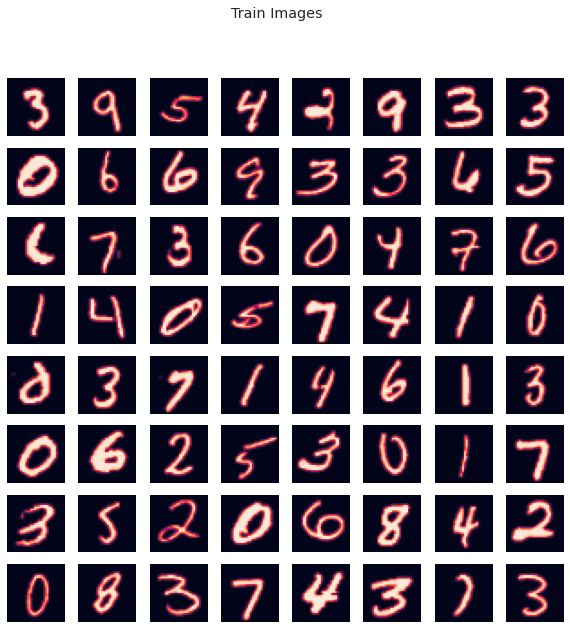

In [ ]:
# Plot some training images
plt.ioff()
real_batch, _ = next(iter(train_loader))
fig = plt.figure(figsize=(10, 10))
plt.title("Training Images")
for idx, image in enumerate(real_batch[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu())
    plt.axis('off')
    plt.grid('off')
# plt.show()
fig.suptitle('Train Images')
plt.show()
# fig.tight_layout()
# fig.savefig('test.jpg')
# plt.close()

In [ ]:
def save_images(data, title='', dest='test.jpg'):
    plt.ioff()
    fig = plt.figure(figsize=(10, 10))
    # fetch the first 64 images only
    for idx, image in enumerate(data[:64]):
        plt.subplot(8, 8, idx+1)
        image.squeeze_(0)
        plt.imshow(image.cpu())
        plt.axis('off')
        plt.grid('off')
    fig.suptitle(title)
    fig.savefig(dest)
    plt.close()

## Train the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = MNISTVAE(nc=1, nf=32, z_dims=10)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from tqdm.auto import tqdm

def train_epoch(epoch, model, optimizer):
    model.train()

    model = model.to(device)

    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)

        optimizer.zero_grad() # zero out the gradients

        output = model(data) # forward pass

        loss = loss_function(output, data) # compute the loss

        loss.backward() # backprop the loss

        train_loss += loss.item()

        optimizer.step() # update the optimizer
    
    print(f'=> Epoch: {epoch}\tAverage Loss: {(train_loss / len(train_loader)):.4f}\n')

In [ ]:
NUM_EPOCHS = 10
out_images = Path('vae_output')
out_images.mkdir(parents=True, exist_ok=True)
for epoch in range(1, NUM_EPOCHS + 1):
    train_epoch(epoch, model, optimizer)

    # with torch.no_grad():
    #     model.eval()
    #     # `64 x z_dims` random array
    #     sample = torch.randn(64, 20, 1, 1).to(device)
    #     sample_out = model.decoder(sample)
    #     sample_out = torch.sigmoid(sample_out)

    # save_images(sample_out, f'Epoch {epoch:02}', dest=f'vae_output/epoch_{epoch:02}')


=> Epoch: 1	Average Loss: 23174.7989




=> Epoch: 2	Average Loss: 17427.9119




=> Epoch: 3	Average Loss: 16764.6961




=> Epoch: 4	Average Loss: 16485.7732




=> Epoch: 5	Average Loss: 16267.3773




=> Epoch: 6	Average Loss: 16140.4039




=> Epoch: 7	Average Loss: 16036.6545




=> Epoch: 8	Average Loss: 15908.5012




=> Epoch: 9	Average Loss: 15849.5020




=> Epoch: 10	Average Loss: 15763.5571



Let's try to see what the model outputs if we provide it with some random z vector

In [ ]:
with torch.no_grad():
    model.eval()
    sample = torch.randn(64, 10, 1, 1).to(device)
    output = model.decoder(sample)

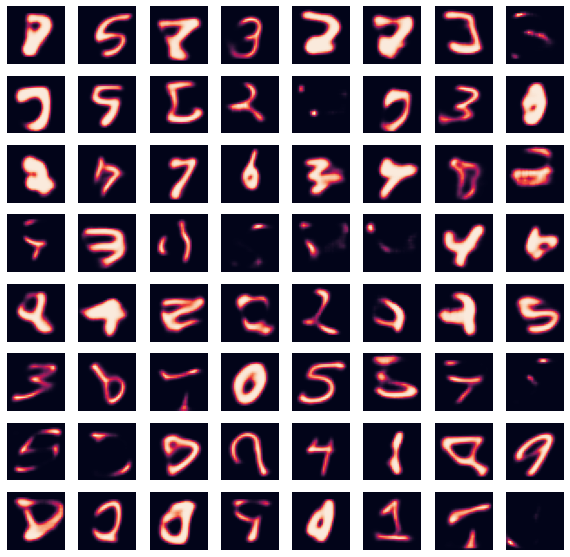

In [ ]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(output[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu())
    plt.axis('off')
    plt.grid('off')

plt.show()

## Lets see how the model reconstructs input images

In [ ]:
batch, _ = next(iter(train_loader))
with torch.no_grad():
    batch = batch.to(device)

    out, mu, logvar = model(batch)

In [ ]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(out[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu())
    plt.axis('off')
    plt.grid('off')
plt.tight_layout()
fig.canvas.draw()
predicted = np.array(fig.canvas.renderer.buffer_rgba())

In [ ]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(batch[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu())
    plt.axis('off')
    plt.grid('off')
plt.tight_layout()
fig.canvas.draw()
real = np.array(fig.canvas.renderer.buffer_rgba())

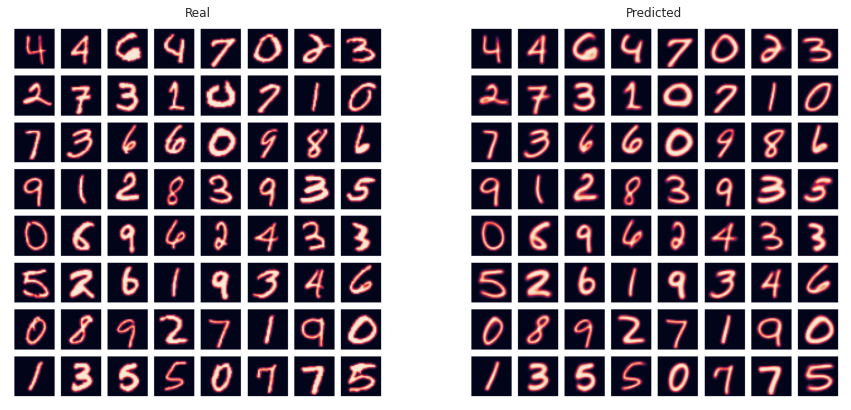

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(real)
plt.title('Real')
plt.grid('off')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title('Predicted')
plt.grid('off')
plt.axis('off')

plt.show()

Playing with the z vector of the reconstructed images

In [ ]:
batch[0].shape

torch.Size([1, 32, 32])

In [ ]:
with torch.no_grad():
    mu, logvar = model.encoder(batch[3].unsqueeze_(0).to(device))
    z = model.reparameterize(mu, logvar)
    z[0][1][0] += 1.5
    z[0][0][0] += -1.5
    out = model.decoder(z)
    out = out.squeeze_(0)

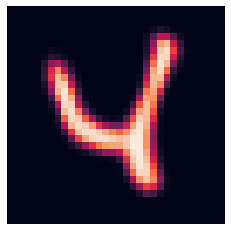

In [ ]:
plt.imshow(out[0].cpu())
plt.axis('off')
plt.grid('off')
plt.show()

In [ ]:
torch.save(model, 'mnist_vae_32x32.pt')

In [ ]:
model = torch.load('mnist_vae_32x32.pt')

In [ ]:
torch.onnx.export(model.encoder,          
                  torch.randn(1, 1, 32, 32).to(device),              
                  "mnist_vae_encoder_32x32.onnx",  
                  export_params=True,        
                  opset_version=12,        
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['output'], 
                  dynamic_axes={'input' : {0 : 'batch_size'},  
                                'output' : {0 : 'batch_size'}})

In [ ]:
torch.onnx.export(model.decoder,          
                  torch.randn(1, 10, 1, 1).to(device),              
                  "mnist_vae_decoder_32x32.onnx",  
                  export_params=True,        
                  opset_version=12,        
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['output'], 
                  dynamic_axes={'input' : {0 : 'batch_size'},  
                                'output' : {0 : 'batch_size'}})

ONNX.js does not support ConvTranspose2D so we will use a custom layer for that

Thanks to https://github.com/a2kiti/ConvTranspose2d_for_ONNX/blob/master/ConvTranpose2D_for_onnxjs.ipynb

In [ ]:
model = torch.load('mnist_vae.pt')

In [ ]:
# custom ConvTranspose2D layer for onnx.js
# onnx.js can't use nn.ConvTranspose2D.
# this custom layer is conposed by torch.cat and nn.Conv2d.
# this layer has some limitations.
# Since shape method is disable, batchsize height and width must be determined.
class ConvTranspose2D_ONNXJS(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, height, width, batch_size):
        super(ConvTranspose2D_ONNXJS, self).__init__(in_channels, out_channels, kernel_size, 1, 0, bias=False)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride_t = stride
        if not (self.stride_t==1 or self.stride_t==2):
            raise Exception("available stride is only 1 or 2.")

        self.padding_t = padding
        self.h = height
        self.w = width
        self.b = batch_size
        self.outpad = self.kernel_size - 1 - self.padding_t
        if self.outpad < (self.stride_t-1):
            raise Exception("outside padding is too little.")
        

    def forward(self, x):
        if self.stride_t == 2:
            #2 stride by concat
            tmp  = x.view(-1,1)
            tmp  = torch.cat([tmp, torch.zeros((self.b * self.in_channels * self.h * self.w, 1))],1)
            tmp = tmp.view(-1, self.w * 2)
            x = torch.cat([tmp,torch.zeros((self.b * self.in_channels * self.h, self.w * 2))], 1).view(-1, self.in_channels, self.h * 2, self.w * 2)
            # outside padding by concat
            hs, ws, he, we = self.outpad, self.outpad, self.outpad, self.outpad
            x = torch.cat([torch.zeros((self.b, self.in_channels, hs, self.w * 2)), x, torch.zeros((self.b, self.in_channels, he-1, self.w * 2))], 2)
            x = torch.cat([torch.zeros((self.b, self.in_channels, self.h * 2+hs+he-1, ws)), x, torch.zeros((self.b, self.in_channels, self.h*2+hs+he-1, we-1))], 3)
        else:
            # outside padding by concat
            hs, ws, he, we = self.outpad, self.outpad, self.outpad, self.outpad
            x = torch.cat([torch.zeros((self.b, self.in_channels, hs, self.w)), x, torch.zeros((self.b, self.in_channels, he, self.w))], 2)
            x = torch.cat([torch.zeros((self.b, self.in_channels, self.h+hs+he, ws)), x, torch.zeros((self.b, self.in_channels, self.h+hs+he, we))], 3)

        x = super().forward(x)
        return x

# ConvTranspose2D weight to Conv2D weight
def convert_weight(nn_weight):
    w = nn_weight[:]
    I, O, H, W = w.shape
    w = w.permute(1,0,2,3)
    w = w[:, :, torch.arange(H-1,-1,-1), :]
    w = w[:, :, :, torch.arange(W-1,-1,-1)]
    return w

In [ ]:
class Decoder_replace(nn.Module):
    """
    Creates the Decoder

    nc (int): channels in the final output
    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nc: int = 1, ngf: int = 16, z_dim: int = 20):
        super(Decoder_replace, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            ConvTranspose2D_ONNXJS( z_dim, ngf * 8, 4, 1, 0, 1, 1, 1),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(),
            # state size. (ngf*4) x 4 x 4
            ConvTranspose2D_ONNXJS( ngf * 8, ngf * 4, 4, 2, 1, 4, 4, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(),
            nn.Conv2d(ngf * 4, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(),
            # state size. (ngf*3) x 8 x 8
            ConvTranspose2D_ONNXJS( ngf * 4, ngf * 2, 4, 2, 1, 8, 8, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),
            nn.Conv2d(ngf * 2, ngf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),
            # state size. (ngf*2) x 16 x 16
            ConvTranspose2D_ONNXJS( ngf * 2, ngf * 2, 4, 2, 1, 16, 16, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),
            nn.Conv2d(ngf * 2, nc, 3, 1, 1, bias=False),
            # state size. (ngf*2) x 32 x 32
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
decoder_r = Decoder_replace(nc=1, ngf=32, z_dim=10)
decoder_r.eval()
for (k, v), (k_r, v_r) in zip(model.decoder.state_dict().items(), decoder_r.state_dict().items()):
    print(k, "->", k_r)
    if len(v.shape)==0:
        v_r = v
    else:
        if len(v.shape)==4:
            v_r[:] = convert_weight(v) # ConvTranspose2D weight to Conv2D weight
        else:
            v_r[:] = v

main.0.weight -> main.0.weight
main.1.weight -> main.1.weight
main.1.bias -> main.1.bias
main.1.running_mean -> main.1.running_mean
main.1.running_var -> main.1.running_var
main.1.num_batches_tracked -> main.1.num_batches_tracked
main.3.weight -> main.3.weight
main.4.weight -> main.4.weight
main.4.bias -> main.4.bias
main.4.running_mean -> main.4.running_mean
main.4.running_var -> main.4.running_var
main.4.num_batches_tracked -> main.4.num_batches_tracked
main.6.weight -> main.6.weight
main.7.weight -> main.7.weight
main.7.bias -> main.7.bias
main.7.running_mean -> main.7.running_mean
main.7.running_var -> main.7.running_var
main.7.num_batches_tracked -> main.7.num_batches_tracked
main.9.weight -> main.9.weight
main.10.weight -> main.10.weight
main.10.bias -> main.10.bias
main.10.running_mean -> main.10.running_mean
main.10.running_var -> main.10.running_var
main.10.num_batches_tracked -> main.10.num_batches_tracked
main.12.weight -> main.12.weight
main.13.weight -> main.13.weight
main

RuntimeError: ignored

In [ ]:
model.decoder

Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, moment

In [ ]:
layers_without_convtranspose2d = [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19]

In [ ]:
decoder_r = Decoder_replace(nc=1, ngf=32, z_dim=10)
decoder_r.eval()
for (k, v), (k_r, v_r) in zip(model.decoder.to('cpu').state_dict().items(), decoder_r.state_dict().items()):
    print(k, "->", k_r)
    if len(v.shape)==0:
        v_r = v
    else:
        # only if the current layer is a ConvTranspose2D
        if len(v.shape) == 4 and not (int(k.split('.')[1]) in layers_without_convtranspose2d) :
            v_r[:] = convert_weight(v) # ConvTranspose2D weight to Conv2D weight
        else:
            v_r[:] = v

main.0.weight -> main.0.weight
main.1.weight -> main.1.weight
main.1.bias -> main.1.bias
main.1.running_mean -> main.1.running_mean
main.1.running_var -> main.1.running_var
main.1.num_batches_tracked -> main.1.num_batches_tracked
main.3.weight -> main.3.weight
main.4.weight -> main.4.weight
main.4.bias -> main.4.bias
main.4.running_mean -> main.4.running_mean
main.4.running_var -> main.4.running_var
main.4.num_batches_tracked -> main.4.num_batches_tracked
main.6.weight -> main.6.weight
main.7.weight -> main.7.weight
main.7.bias -> main.7.bias
main.7.running_mean -> main.7.running_mean
main.7.running_var -> main.7.running_var
main.7.num_batches_tracked -> main.7.num_batches_tracked
main.9.weight -> main.9.weight
main.10.weight -> main.10.weight
main.10.bias -> main.10.bias
main.10.running_mean -> main.10.running_mean
main.10.running_var -> main.10.running_var
main.10.num_batches_tracked -> main.10.num_batches_tracked
main.12.weight -> main.12.weight
main.13.weight -> main.13.weight
main

Lets check if they have the same output

In [ ]:
with torch.no_grad():
    z = torch.randn(1, 10, 1, 1)
    out = decoder_r(z)
    out.squeeze_(0)

    out2 = model.decoder(z)
    out2.squeeze_(0)

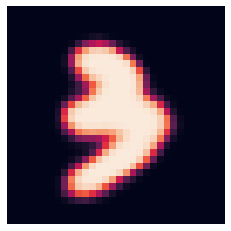

In [ ]:
plt.imshow(out[0].cpu())
plt.axis('off')
plt.grid('off')
plt.show()

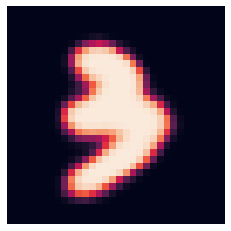

In [ ]:
plt.imshow(out2[0].cpu())
plt.axis('off')
plt.grid('off')
plt.show()

In [ ]:
torch.onnx.export(decoder_r.to('cpu'),          
                  torch.randn(1, 10, 1, 1),              
                  "mnist_vae_decoder_32x32_onnxjs.onnx",  
                  export_params=True,        
                  opset_version=12,        
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['output'], 
                  dynamic_axes={'input' : {},  
                                'output' : {}})

In [ ]:
torch.onnx.export(decoder_r,          
                  torch.randn(1, 10, 1, 1),              
                  "mnist_vae_decoder_10.onnx")

In [ ]:
torch.onnx.export(model.decoder,          
                  torch.randn(1, 10, 1, 1).to(device),              
                  "mnist_vae_decoder_2.onnx",  
                  export_params=True,        
                  opset_version=10,        
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['output'], 
                  dynamic_axes={'input' : {0 : 'batch_size'},  
                                'output' : {0 : 'batch_size'}})

In [ ]:
class Decoder_replace(nn.Module):
    """
    Creates the Decoder

    nc (int): channels in the final output
    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nc: int = 1, ngf: int = 16, z_dim: int = 20):
        super(Decoder_replace, self).__init__()


        # input is Z, going into a convolution
        self.conv0 = ConvTranspose2D_ONNXJS( z_dim, ngf * 8, 4, 1, 0, 1, 1, 1)
        self.bn0 = nn.BatchNorm2d(ngf * 8)
        self.act0 = nn.ReLU()
        # state size. (ngf*4) x 4 x 4
        self.conv1 = ConvTranspose2D_ONNXJS( ngf * 8, ngf * 4, 4, 2, 1, 4, 4, 1)
        self.bn1 = nn.BatchNorm2d(ngf * 4)
        self.act1 = nn.ReLU()
        self.conv11 = nn.Conv2d(ngf * 4, ngf * 4, 3, 1, 1, bias=False)
        self.bn11 = nn.BatchNorm2d(ngf * 4)
        self.act11 = nn.ReLU()
        # state size. (ngf*3) x 8 x 8
        self.conv2 = ConvTranspose2D_ONNXJS( ngf * 4, ngf * 2, 4, 2, 1, 8, 8, 1)
        self.bn2 = nn.BatchNorm2d(ngf * 2)
        self.act2 = nn.ReLU()
        self.conv21 = nn.Conv2d(ngf * 2, ngf * 2, 3, 1, 1, bias=False)
        self.bn21 = nn.BatchNorm2d(ngf * 2)
        self.act21 = nn.ReLU()
        # state size. (ngf*2) x 14 x 14
        self.conv3 = ConvTranspose2D_ONNXJS( ngf * 2, nc, 4, 2, 1, 16, 16, 1)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.act3 = nn.ReLU()
        self.conv31 = nn.Conv2d(ngf * 2, nc, 3, 1, 1, bias=False)
        # state size. (ngf*2) x 28 x 28
        self.actf = nn.Sigmoid()


    def forward(self, input):
        x = self.conv0(input)
        x = self.bn0(x)
        x = self.act0(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        # x = self.conv11(x)
        # x = self.bn11(x)
        # x = self.act11(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        # x = self.conv21(x)
        # x = self.bn21(x)
        # x = self.act21(x)

        x = self.conv3(x)
        # x = self.bn3(x)
        # x = self.act3(x)
        # x = self.conv31(x)

        x = self.actf(x)

        return x

In [ ]:
class Generator_replace(nn.Module):
    def __init__(self, nz=100, nch_g=64, nch=1, ):
        super(Generator_replace, self).__init__()

        # (100, 1, 1) -> (256, 4, 4)
        self.conv0 = ConvTranspose2D_ONNXJS(nz, nch_g * 4, 4, 1, 0, 1, 1, 1)
        self.bn0 = nn.BatchNorm2d(nch_g * 4)
        self.act0 = nn.ReLU()

        self.conv01 = nn.Conv2d(nch_g * 4, nch_g * 4, 3, 1, 1,bias=False)
        
        # (256, 4, 4) -> (128, 8, 8)
        self.conv1 = ConvTranspose2D_ONNXJS(nch_g*4, nch_g * 2, 4, 2, 1, 4, 4, 1)
        self.bn1 = nn.BatchNorm2d(nch_g * 2)
        self.act1 = nn.ReLU()
        
        # (128, 8, 8) -> (64, 16, 16)
        self.conv2 = ConvTranspose2D_ONNXJS(nch_g*2, nch_g * 1, 4, 2, 1, 8, 8, 1)
        self.bn2 = nn.BatchNorm2d(nch_g * 1)
        self.act2 = nn.ReLU()
        
        # (64, 16, 16) -> (1, 32, 32)
        self.conv3 = ConvTranspose2D_ONNXJS(nch_g*1, nch, 4, 2, 1, 16, 16, 1)
        self.act3 = nn.Tanh()
        
    def forward(self, z):
        z = self.conv0(z)
        z = self.bn0(z)
        z = self.act0(z)
        z = self.conv01(z)

        z = self.conv1(z)
        z = self.bn1(z)
        z = self.act1(z)

        z = self.conv2(z)
        z = self.bn2(z)
        z = self.act2(z)

        z = self.conv3(z)
        z = self.act3(z)
        return z

In [ ]:
gen_r = Generator_replace(nz=10)

In [ ]:
decoder_r = Decoder_replace(nc=1, ngf=32, z_dim=10)

In [ ]:
decoder_r(torch.randn(1, 10, 1, 1)).shape

torch.Size([1, 1, 32, 32])

In [ ]:
gen_r(torch.randn(1, 10, 1, 1)).shape

torch.Size([1, 1, 32, 32])

In [ ]:
torch.onnx.export(decoder_r.to('cpu'),          
                  torch.randn(1, 10, 1, 1),              
                  "mnist_vae_decoder_15.onnx",  
                  export_params=True,        
                  opset_version=12,        
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['output'], 
                  dynamic_axes={'input' : {},  
                                'output' : {}})

In [ ]:
torch.onnx.export(gen_r.to('cpu'),          
                  torch.randn(1, 10, 1, 1),              
                  "mnist_vae_decoder_13.onnx",  
                  export_params=True,        
                  opset_version=12,        
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['output'], 
                  dynamic_axes={'input' : {},  
                                'output' : {}})

In [ ]:
summary(gen_r, input_size=(10, 1, 1), device='cpu')

RuntimeError: ignored

In [ ]:
summary(decoder_r, input_size=(10, 1, 1), device='cpu')

RuntimeError: ignored

In [ ]:
!pip install onnxruntime

     |████████████████████████████████| 4.4MB 2.8MB/s 


In [ ]:
import onnxruntime

In [ ]:
import onnxruntime
session = onnxruntime.InferenceSession("mnist_vae_decoder_10.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

ort_outs = session.run([output_name], {input_name: to_numpy(torch.randn(1, 10, 1, 1))})

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


## Trying out a simpler model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
            Linear-2                   [-1, 20]           8,020
            Linear-3                   [-1, 20]           8,020
            Linear-4                  [-1, 400]           8,400
            Linear-5                  [-1, 784]         314,384
Total params: 652,824
Trainable params: 652,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.49
Estimated Total Size (MB): 2.51
----------------------------------------------------------------


In [ ]:
def kld(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def loss_function(y_pred, y_true):

    recon_x, mu, logvar = y_pred

    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), y_true.view(-1, 784), reduction='sum')

    B, C, H, W = recon_x.size()
    KLD = kld(mu, logvar)
    KLD /= B

    return BCE + KLD

In [ ]:
from tqdm.auto import tqdm

def train_epoch(epoch, model, optimizer):
    model.train()

    model = model.to(device)

    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)

        optimizer.zero_grad() # zero out the gradients

        output = model(data) # forward pass

        loss = loss_function(output, data) # compute the loss

        loss.backward() # backprop the loss

        train_loss += loss.item()

        optimizer.step() # update the optimizer
    
    print(f'=> Epoch: {epoch}\tAverage Loss: {(train_loss / len(train_loader)):.4f}\n')

In [ ]:
NUM_EPOCHS = 10
out_images = Path('vae_output')
out_images.mkdir(parents=True, exist_ok=True)
for epoch in range(1, NUM_EPOCHS + 1):
    train_epoch(epoch, model, optimizer)

    with torch.no_grad():
        model.eval()
        # `64 x z_dims` random array
        sample = torch.randn(64, 20, 1, 1).to(device)
        sample_out = model.decode(sample.view(-1, 20))

    save_images(sample_out, f'Epoch {epoch:02}', dest=f'vae_output/epoch_{epoch:02}')


=> Epoch: 1	Average Loss: 8759.3844




=> Epoch: 2	Average Loss: 8710.2371




=> Epoch: 3	Average Loss: 8669.6586




=> Epoch: 4	Average Loss: 8632.2311




=> Epoch: 5	Average Loss: 8597.8611




=> Epoch: 6	Average Loss: 8565.2327




=> Epoch: 7	Average Loss: 8540.3465




=> Epoch: 8	Average Loss: 8515.7285




=> Epoch: 9	Average Loss: 8489.5991




=> Epoch: 10	Average Loss: 8468.2747



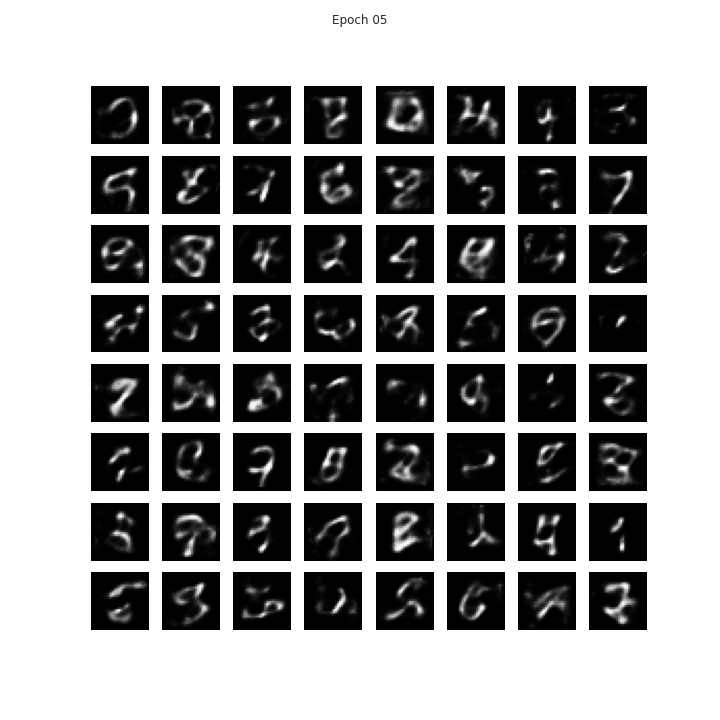

In [ ]:
Image.open('/content/vae_output/epoch_05.png')

In [ ]:
batch, _ = next(iter(train_loader))
with torch.no_grad():
    batch = batch.to(device)

    out, mu, logvar = model(batch)


In [ ]:
out.shape

torch.Size([128, 1, 28, 28])

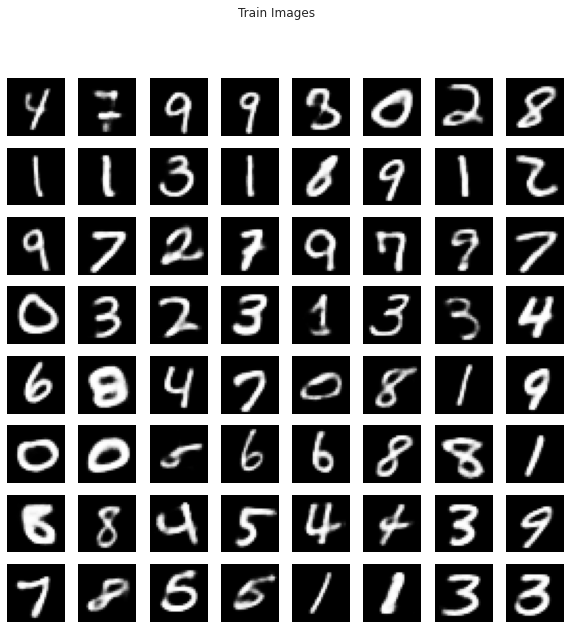

In [ ]:
fig = plt.figure(figsize=(10, 10))
for idx, image in enumerate(out[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu(), cmap='gray')
    plt.axis('off')
    plt.grid('off')
plt.show()

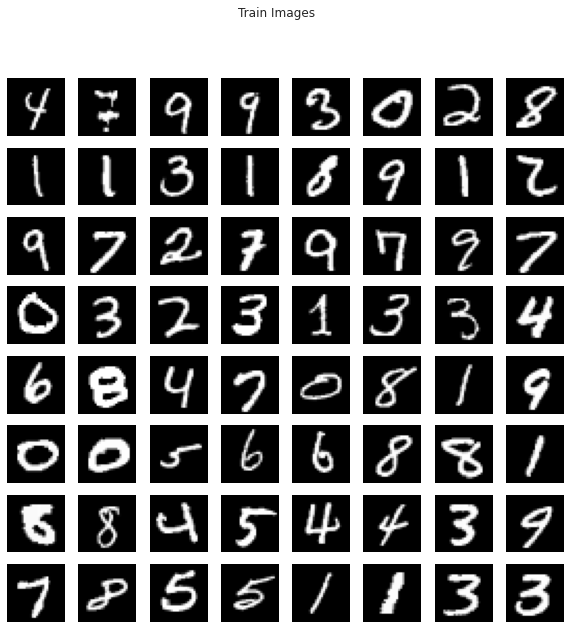

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.title("Training Images")
for idx, image in enumerate(batch[:64]):
    plt.subplot(8, 8, idx+1)
    image.squeeze_(0)
    plt.imshow(image.cpu(), cmap='gray')
    plt.axis('off')
    plt.grid('off')
fig.suptitle('Train Images')
plt.show()